# GAN

GAN to generate MNIST digits

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

def plot_samples(samples, h=5, w=10):
    fig, axes = plt.subplots(nrows=h,
                             ncols=w,
                             figsize=(int(1.4 * w), int(1.4 * h)),
                             subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i], cmap='gray')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

bs = 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [2]:
# Define the generator and discriminator

class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 128)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))
    
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [3]:
loss_func = nn.BCELoss() 

# Define two optimizers for G and D
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

### Generator loss

In [4]:
def G_train(x):
    '''
    x: Real data
    Return: The value of the generator loss
    '''
    
    
    G.zero_grad()
    # Sample noise
    z = torch.randn(bs, z_dim).to(device)
    y = torch.ones(bs, 1).to(device)

    G_output = G(z) # Call the generator
    D_output = D(G_output) # Call the discriminator
    G_loss = loss_func(D_output, y)

    # gradient backprop & optimize G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    
    return G_loss.data.item()

### Discriminator loss

In [5]:
def D_train(x):
    '''
    x: Real data
    Return: The value of the discriminator loss
    '''
    
    D.zero_grad()

    # train discriminator on real data
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1).to(device)

    D_real_loss = loss_func(D(x_real), y_real)

    # train discriminator on fake data, i.e. the one from G
    z = torch.randn(bs, z_dim).to(device)
    x_fake, y_fake = G(z), torch.zeros(bs, 1).to(device)

    D_fake_loss = loss_func(D(x_fake), y_fake)

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

### Training

In [6]:
n_epoch = 20
D_losses_epoch = []
G_losses_epoch = []
for epoch in tqdm(range(1, n_epoch+1)):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    D_losses_epoch.append(torch.mean(torch.FloatTensor(D_losses)))
    G_losses_epoch.append(torch.mean(torch.FloatTensor(G_losses)))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

  5%|██▏                                         | 1/20 [00:06<02:04,  6.56s/it]

[1/20]: loss_d: 1.089, loss_g: 1.093


 10%|████▍                                       | 2/20 [00:12<01:51,  6.19s/it]

[2/20]: loss_d: 1.211, loss_g: 0.948


 15%|██████▌                                     | 3/20 [00:18<01:43,  6.09s/it]

[3/20]: loss_d: 1.094, loss_g: 1.233


 20%|████████▊                                   | 4/20 [00:25<01:41,  6.33s/it]

[4/20]: loss_d: 1.134, loss_g: 1.163


 25%|███████████                                 | 5/20 [00:31<01:33,  6.22s/it]

[5/20]: loss_d: 0.838, loss_g: 1.672


 30%|█████████████▏                              | 6/20 [00:37<01:26,  6.15s/it]

[6/20]: loss_d: 0.851, loss_g: 1.660


 35%|███████████████▍                            | 7/20 [00:43<01:19,  6.12s/it]

[7/20]: loss_d: 1.006, loss_g: 1.302


 40%|█████████████████▌                          | 8/20 [00:49<01:12,  6.08s/it]

[8/20]: loss_d: 0.781, loss_g: 1.743


 45%|███████████████████▊                        | 9/20 [00:55<01:08,  6.25s/it]

[9/20]: loss_d: 0.943, loss_g: 1.459


 50%|█████████████████████▌                     | 10/20 [01:04<01:09,  6.90s/it]

[10/20]: loss_d: 0.789, loss_g: 1.769


 55%|███████████████████████▋                   | 11/20 [01:11<01:03,  7.00s/it]

[11/20]: loss_d: 0.874, loss_g: 1.666


 60%|█████████████████████████▊                 | 12/20 [01:17<00:54,  6.77s/it]

[12/20]: loss_d: 0.923, loss_g: 1.518


 65%|███████████████████████████▉               | 13/20 [01:23<00:45,  6.54s/it]

[13/20]: loss_d: 0.964, loss_g: 1.430


 70%|██████████████████████████████             | 14/20 [01:30<00:39,  6.56s/it]

[14/20]: loss_d: 0.974, loss_g: 1.379


 75%|████████████████████████████████▎          | 15/20 [01:36<00:32,  6.45s/it]

[15/20]: loss_d: 0.934, loss_g: 1.495


 80%|██████████████████████████████████▍        | 16/20 [01:43<00:26,  6.53s/it]

[16/20]: loss_d: 0.923, loss_g: 1.471


 85%|████████████████████████████████████▌      | 17/20 [01:49<00:19,  6.40s/it]

[17/20]: loss_d: 0.944, loss_g: 1.484


 90%|██████████████████████████████████████▋    | 18/20 [01:55<00:12,  6.39s/it]

[18/20]: loss_d: 0.988, loss_g: 1.368


 95%|████████████████████████████████████████▊  | 19/20 [02:02<00:06,  6.44s/it]

[19/20]: loss_d: 0.960, loss_g: 1.445


100%|███████████████████████████████████████████| 20/20 [02:08<00:00,  6.42s/it]

[20/20]: loss_d: 1.052, loss_g: 1.291


**Plots for `D_losses` and `G_losses`**

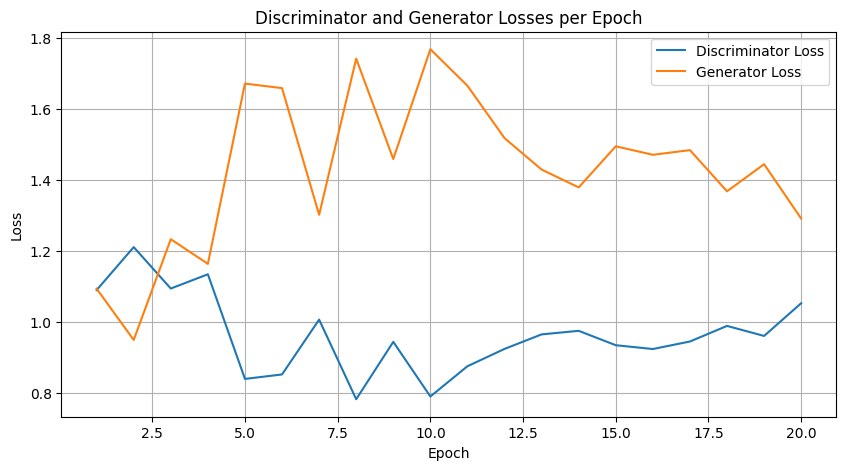

In [7]:
# Plot the D_losses and G_losses in one figure, with epoch being the x-axis

plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epoch+1), D_losses_epoch, label='Discriminator Loss')
plt.plot(range(1, n_epoch+1), G_losses_epoch, label='Generator Loss')
plt.title('Discriminator and Generator Losses per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



**Discriminator Loss:**

It decreases initially as the discriminator learns to distinguish between real and fake data. As the generator gets better at generating more realistic data, the discriminator loss increases. So, the discriminator loss is neither monotonically decreasing nor increasing throughout training.

**Generator Loss:**

Initially, the generator might not generate realistic data, leading to a higher loss. As training progresses, this loss decreases.
If the discriminator becomes too good at distinguishing between real and fake data, the generator might find it harder to improve, leading to an increase in loss.
So, the behavior of the losses is not necessarily monotonic; they fluctuate throughout the training process. There will be fluctuations in both losses as the generator and discriminator are in a min-max game.


### Sample generation

Samples using the learned generator.

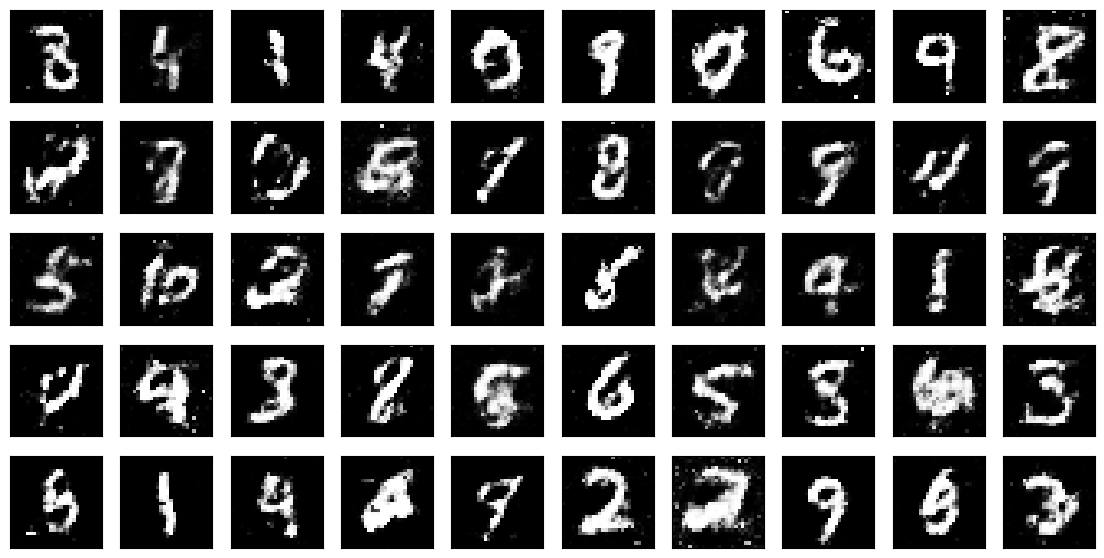

In [12]:
with torch.no_grad():
    z = torch.randn(50, z_dim)
    generated = G(z)
    
plot_samples(generated.reshape(-1, 28, 28))

# Score matching

Original score matching objective (without the integral-by-part trick) to fit the score function of a 2-D Gaussian.


### Score function

In [13]:
from torch.distributions import MultivariateNormal
from torch.func import grad, vmap
mean = torch.tensor([1.0, 2.0])
cov = torch.tensor([
    [1.0, 0.5], [0.5, 1.0]
])
mvn = MultivariateNormal(loc=mean, covariance_matrix=cov)

def score_func(x1, x2, mean, cov):
    """
    x1, x2: Values for the first and second dimension of the observed samples,
        both are torch tensors of shape (N, 1)
    mean: Mean of the gaussian of shape (2,)
    cov: Covariance of the gaussian of shape (2, 2)
    
    Return:
    A tensor of shape (N, 2) denoting the score
    """

    x = torch.vstack([x1, x2]).T

    cov_inv = torch.inverse(cov)
    x_diff = x - mean
    grad_x = -cov_inv @ x_diff.T  # Shape: (2, N)
    score = grad_x.T
    
    return score

In [14]:
# Test to check the score function at  X = (1, 1)
print('Your implementation', score_func(torch.ones(1,), torch.ones(1,), mean, cov).squeeze().numpy())

ground_truth = grad(lambda x: mvn.log_prob(x).mean())
print('Ground truth value', ground_truth(torch.ones(2,)).numpy())

Your implementation [-0.6666667  1.3333334]
Ground truth value [-0.6666666  1.3333333]


## Score function inspection

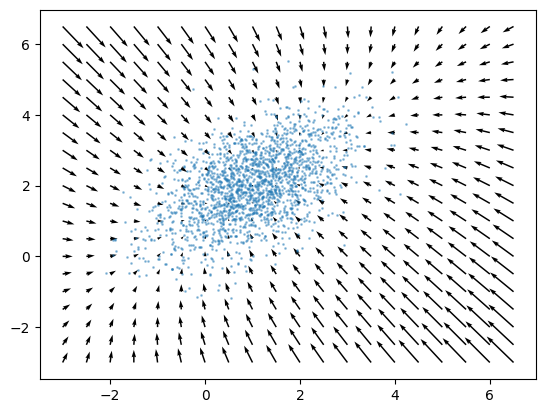

In [15]:
x = torch.arange(-3, 7, step=0.5)
y = torch.arange(-3, 7, step=0.5)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
stacked_xy = torch.stack([grid_x, grid_y], dim=-1).reshape(-1, 2)

score = score_func(stacked_xy[:, 0], stacked_xy[:, 1], mean, cov).reshape(len(x), len(y), 2).detach().numpy()
plt.quiver(grid_x.numpy(),grid_y.numpy(), score[..., 0], score[..., 1])
samples = mvn.sample((2000,))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.4, s=1.0)

```
The direction is towards the nearest mode (peak) of the distribution. Magnitude of score is large when x is farther from the peak of the distribution.
```

## Score matching, part 1
Use a neural network, `s_x`, to fit the score using the score matching objective. Notice that since the closed form of score function is known, integration-by-part trick is not used. Instead, the fisher divergence can be minimized directly.

Minimizing the fisher divergence is essentially a regression task, at each iteration, draw a bunch of samples from the `mvn` defined above,
then feed it into `s_x` to get an approximation of the score,
and feed it to the implementation of `score_func` to get the true value of the score.

Then you use MSE loss and backpropagation to make `s_x` a nice approximation of `score_func`

In [16]:
# Define the network and the optimizer

s_x = nn.Sequential(
    nn.Linear(2, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 2))

optim = torch.optim.Adam(
        s_x.parameters(), lr=1e-3)

In [17]:
BS = 100
loss = nn.MSELoss()

for Iter in range(1000):
    # perform the optimization
    samples = mvn.sample((BS,))
    s_theta = s_x (samples)
    s_data = score_func(samples[:, 0], samples[:, 1], mean, cov)
    optim.zero_grad()
    loss_value = 0.5 * loss(s_theta, s_data)
    loss_value.backward()
    optim.step()
    # Print Loss
    if Iter % 50 == 0:
        print(f'Iter {Iter}: Loss = {loss_value}')

Iter 0: Loss = 0.6588679552078247
Iter 50: Loss = 0.27474910020828247
Iter 100: Loss = 0.05918443202972412
Iter 150: Loss = 0.008841132745146751
Iter 200: Loss = 0.0016477545723319054
Iter 250: Loss = 0.002003655768930912
Iter 300: Loss = 0.0011915138456970453
Iter 350: Loss = 0.0016591617604717612
Iter 400: Loss = 0.0007705218158662319
Iter 450: Loss = 0.0008276504813693464
Iter 500: Loss = 0.0006551749538630247
Iter 550: Loss = 0.0004013455763924867
Iter 600: Loss = 0.00042621968896128237
Iter 650: Loss = 0.0005064567667432129
Iter 700: Loss = 0.0002585288311820477
Iter 750: Loss = 0.0002979235432576388
Iter 800: Loss = 0.00013525296526495367
Iter 850: Loss = 0.0002982956648338586
Iter 900: Loss = 0.00015849653573241085
Iter 950: Loss = 0.00020233113900758326


Text(0.5, 1.0, 'Approximate score')

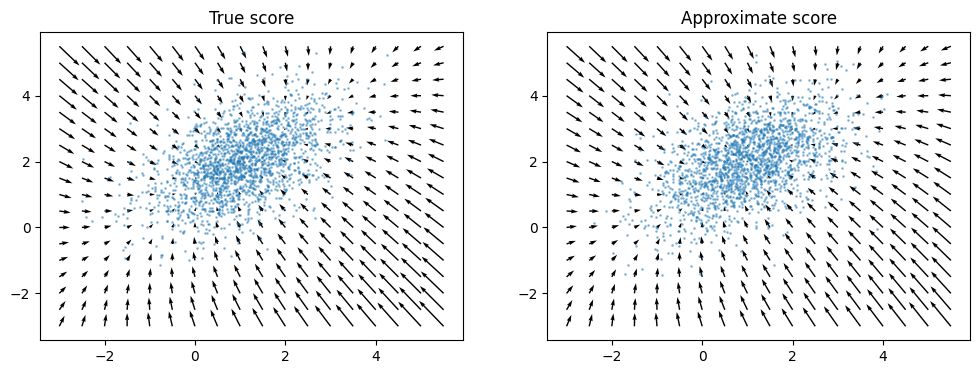

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

x = torch.arange(-3, 6, step=0.5)
y = torch.arange(-3, 6, step=0.5)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
stacked_xy = torch.stack([grid_x, grid_y], dim=-1).reshape(-1, 2)

# True score
score = score_func(stacked_xy[:, 0], stacked_xy[:, 1], mean, cov).reshape(len(x), len(y), 2).detach().numpy()
ax[0].quiver(grid_x.numpy(),grid_y.numpy(), score[..., 0], score[..., 1])
samples = mvn.sample((2000,))
ax[0].scatter(samples[:, 0], samples[:, 1], alpha=0.4, s=1.0)
ax[0].set_title('True score')

# Approximate score
score = s_x(stacked_xy).reshape(len(x), len(y), 2).detach().numpy()
ax[1].quiver(grid_x.numpy(),grid_y.numpy(), score[..., 0], score[..., 1])
samples = mvn.sample((2000,))
ax[1].scatter(samples[:, 0], samples[:, 1], alpha=0.4, s=1.0)
ax[1].set_title('Approximate score')

## Score matching, part 2

Now, assume the true score is not accessible. So, the objective is acquired using integration-by-part trick.

**Learning Rate = 1e-4**

In [19]:
# Let's create another copy of the network

s_x_2 = nn.Sequential(
    nn.Linear(2, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 2))

optim = torch.optim.Adam(
        s_x_2.parameters(), lr=1e-4)

In [20]:
from torch.autograd.functional import hessian, jacobian

BS = 100

for Iter in range(1000):
    samples = mvn.sample((BS,))
    grad_s_theta = torch.zeros(BS, 2, 2)
    trace_grad_s_theta = 0
    for i in range(BS):
        grad_s_theta[i] = jacobian(s_x_2, samples[i], create_graph=True)
        trace_grad_s_theta +=  torch.trace(grad_s_theta[i])
    optim.zero_grad()
    loss_value = 0.5 * torch.sum(s_x_2(samples).pow(2), dim=1).mean() + (trace_grad_s_theta / BS)
    loss_value.backward()
    optim.step()
    # Print Loss
    if Iter % 50 == 0:
        print(f'Iter {Iter}: Loss = {loss_value}')

Iter 0: Loss = 0.03451947867870331
Iter 50: Loss = -0.04359349235892296
Iter 100: Loss = -0.1103883907198906
Iter 150: Loss = -0.1770572066307068
Iter 200: Loss = -0.2438122034072876
Iter 250: Loss = -0.27808594703674316
Iter 300: Loss = -0.33160823583602905
Iter 350: Loss = -0.3748002350330353
Iter 400: Loss = -0.4279070794582367
Iter 450: Loss = -0.4134989082813263
Iter 500: Loss = -0.44537702202796936
Iter 550: Loss = -0.4396637976169586
Iter 600: Loss = -0.5063349604606628
Iter 650: Loss = -0.49584564566612244
Iter 700: Loss = -0.5135481953620911
Iter 750: Loss = -0.5485107898712158
Iter 800: Loss = -0.5119673013687134
Iter 850: Loss = -0.5728246569633484
Iter 900: Loss = -0.5995724201202393
Iter 950: Loss = -0.5868699550628662


Text(0.5, 1.0, 'Approximate score')

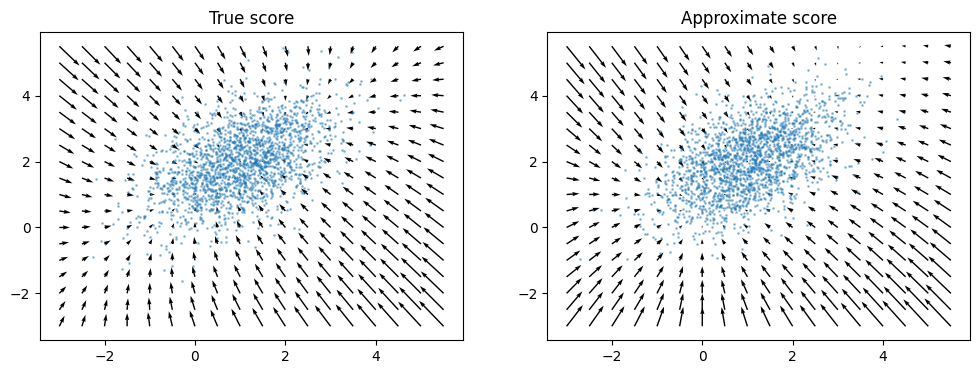

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

x = torch.arange(-3, 6, step=0.5)
y = torch.arange(-3, 6, step=0.5)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
stacked_xy = torch.stack([grid_x, grid_y], dim=-1).reshape(-1, 2)

# True score
score = score_func(stacked_xy[:, 0], stacked_xy[:, 1], mean, cov).reshape(len(x), len(y), 2).detach().numpy()
ax[0].quiver(grid_x.numpy(),grid_y.numpy(), score[..., 0], score[..., 1])
samples = mvn.sample((2000,))
ax[0].scatter(samples[:, 0], samples[:, 1], alpha=0.4, s=1.0)
ax[0].set_title('True score')

# Approximate score
score = s_x_2(stacked_xy).reshape(len(x), len(y), 2).detach().numpy()
ax[1].quiver(grid_x.numpy(),grid_y.numpy(), score[..., 0], score[..., 1])
samples = mvn.sample((2000,))
ax[1].scatter(samples[:, 0], samples[:, 1], alpha=0.4, s=1.0)
ax[1].set_title('Approximate score')

**Learning Rate = 1e-2**

In [22]:
s_x_2 = nn.Sequential(
    nn.Linear(2, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 2))

optim = torch.optim.Adam(
        s_x_2.parameters(), lr=1e-2)

In [23]:
from torch.autograd.functional import hessian, jacobian

BS = 100

for Iter in range(1000):
    # Your code starts here
    samples = mvn.sample((BS,))
    grad_s_theta = torch.zeros(BS, 2, 2)
    trace_grad_s_theta = 0
    optim.zero_grad()
    for i in range(BS):
        grad_s_theta[i] = jacobian(s_x_2, samples[i], create_graph=True)
        trace_grad_s_theta +=  torch.trace(grad_s_theta[i])
    # loss_value = 0.5 * torch.linalg.vector_norm(s_x_2(samples), ord=2, dim=1).pow(2).mean() + (trace_grad_s_theta / BS)
    loss_value = 0.5 * torch.sum(s_x_2(samples).pow(2), dim=1).mean() + (trace_grad_s_theta / BS)
    loss_value.backward()
    optim.step()
    # Print loss
    if Iter % 50 == 0:
        print(f'Iter {Iter}: Loss = {loss_value}')

Iter 0: Loss = 0.00931837409734726
Iter 50: Loss = -0.28762346506118774
Iter 100: Loss = -0.08014900237321854
Iter 150: Loss = -0.008093520067632198
Iter 200: Loss = -0.007966701872646809
Iter 250: Loss = 1.0325564971935819e-06
Iter 300: Loss = -0.014343244023621082
Iter 350: Loss = 3.525998124587204e-07
Iter 400: Loss = 6.664260254751753e-09
Iter 450: Loss = 1.0590713372948812e-06
Iter 500: Loss = 1.3855403935281174e-08
Iter 550: Loss = 6.575295169453099e-11
Iter 600: Loss = 2.2732561818193664e-13
Iter 650: Loss = 2.74088585161536e-10
Iter 700: Loss = 1.1334907235038827e-08
Iter 750: Loss = 1.2128204218697647e-07
Iter 800: Loss = 6.782962458373731e-08
Iter 850: Loss = 4.069147685470398e-09
Iter 900: Loss = 7.955708314355547e-10
Iter 950: Loss = 9.822723967545244e-08


Text(0.5, 1.0, 'Approximate score')

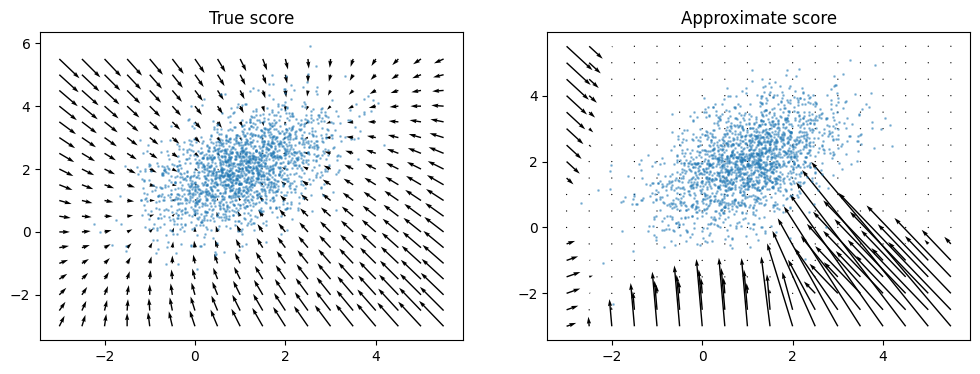

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

x = torch.arange(-3, 6, step=0.5)
y = torch.arange(-3, 6, step=0.5)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
stacked_xy = torch.stack([grid_x, grid_y], dim=-1).reshape(-1, 2)

# True score
score = score_func(stacked_xy[:, 0], stacked_xy[:, 1], mean, cov).reshape(len(x), len(y), 2).detach().numpy()
ax[0].quiver(grid_x.numpy(),grid_y.numpy(), score[..., 0], score[..., 1])
samples = mvn.sample((2000,))
ax[0].scatter(samples[:, 0], samples[:, 1], alpha=0.4, s=1.0)
ax[0].set_title('True score')

# Approximate score
score = s_x_2(stacked_xy).reshape(len(x), len(y), 2).detach().numpy()
ax[1].quiver(grid_x.numpy(),grid_y.numpy(), score[..., 0], score[..., 1])
samples = mvn.sample((2000,))
ax[1].scatter(samples[:, 0], samples[:, 1], alpha=0.4, s=1.0)
ax[1].set_title('Approximate score')

```
The loss converged faster compared to lr = 1e-4. But the loss is high (in order of 1e-8) after 1000 iterations because of the instability in the optimization process. So, we observe larger score magnitudes for points farther from the peak due to comparitively large gradient updates occuring from a higher learning rate.

After rapid convergence in the first few iterations, the loss value overshoots and starts oscillating randomly around the minimum due to a high learning rate. To mitigate this, we can decay the learning rate when the loss starts to bounce around the minimum to obtain the optimum value.
```